## 1. Inspect file
If there is going to be something strange in the data you can bet it'll be in the beginning or end. So we will look at those first to try to spot stupid stuff.

In [ ]:
!head -4 /home/jsignell/data/ShortCreek/Aug2016/CaneBeds.txt

In [ ]:
!tail -4 /home/jsignell/data/ShortCreek/Aug2016/CaneBeds.txt

## 2. Read data into pandas.Dataframe object
This is probably the most iterative step. By the end you want a time parsed and indexed dataframe

In [1]:
import os
import pandas as pd
import xarray as xr

In [2]:
DATA_DIR = '/home/jsignell/data/ShortCreek/'

In [3]:
f = DATA_DIR+'Aug2016/CaneBeds.txt'

In [4]:
gage = pd.read_csv(f, delim_whitespace=True, skiprows=1, usecols=[0,1,2],
                   parse_dates=[['Date', 'Time']], index_col=0)
gage.index.name = 'time'
gage = gage.sort_index()
gage.head()

,inches
time,
2016-07-12 14:22:32,9.76
2016-07-13 02:22:33,9.76
2016-07-13 14:22:34,9.76
2016-07-14 02:22:35,9.76
2016-07-14 14:22:35,9.76


This accumulation is a cumulative sum in inches. We would prefer it to be in mm, and the accumulation between time steps only.

In [5]:
gage = gage.diff()
gage *= 25.4

Be sure to hold on to any information conveyed in the first line of the file. We will look into this in more detail later.

In [6]:
with open(f) as f0:
    meta = f0.readlines()[0]
meta

'Sensor # 7444  Cane Beds Precipitation_Gage \n'

### TZ

In [7]:
gage = gage.tz_localize('US/Arizona').tz_convert('UTC')

### Inter-tip-time
It is important to know the standard time between tips. We can normally get this by looking at the distribution of time intervals between tips. 

In [8]:
pd.TimedeltaIndex(pd.np.diff(gage.index))

TimedeltaIndex(['0 days 12:00:01', '0 days 12:00:01', '0 days 12:00:01',
                '0 days 12:00:00', '0 days 12:00:01', '1 days 00:00:02',
                '0 days 12:00:01', '0 days 12:00:01', '0 days 12:00:01',
                '0 days 12:00:01', '1 days 00:00:02', '0 days 12:00:01',
                '0 days 12:00:01', '0 days 12:00:01', '0 days 12:00:01',
                '0 days 12:00:01', '0 days 12:00:01', '0 days 12:00:01',
                '0 days 12:00:01', '0 days 12:00:01', '0 days 12:00:01',
                '0 days 12:00:01', '0 days 02:35:49', '0 days 09:24:12',
                '0 days 12:00:00', '0 days 12:00:01', '0 days 12:00:01',
                '0 days 12:00:01', '0 days 11:59:59', '0 days 12:00:01',
                '0 days 12:00:01', '1 days 12:00:03', '0 days 12:00:01',
                '0 days 06:36:22', '0 days 00:03:40', '0 days 00:03:36',
                '0 days 01:04:47', '0 days 02:44:20', '0 days 01:27:16',
                '0 days 12:00:01', '0 days 12:00:01

## 3. Read locations into pandas.Dataframe object
The locations can be wonky, but the files are small and locations matter a lot, so don't skimp on the data wrangling at this stage. 

In [9]:
!head -4 /home/jsignell/data/ShortCreek/location.txt

"Cane Beds" 7444 36 57 09 – 112 57 34 5002 feet
"Short Creek @ Central" 7455 36 59 48 – 112 58 32 4984 feet
"Moccasin" 1595 36 54 21 – 112 45 18 5043 feet
"Craigs Knoll" 7436 36 28 16 – 113 10 18 6589 feet


Ok well that is unreadable, because the columns are not separated at all really. This is a case where we need to do some maunal file editing. I added quotes around the station names. 

In [10]:
!head -4 /home/jsignell/data/ShortCreek/location.txt

"Cane Beds" 7444 36 57 09 – 112 57 34 5002 feet
"Short Creek @ Central" 7455 36 59 48 – 112 58 32 4984 feet
"Moccasin" 1595 36 54 21 – 112 45 18 5043 feet
"Craigs Knoll" 7436 36 28 16 – 113 10 18 6589 feet


In [11]:
f = '/home/jsignell/data/ShortCreek/location.txt'

In [12]:
locs = pd.read_csv(f, delim_whitespace=True, nrows=7, header=None)
locs

,0,1,2,3,4,5,6,7,8,9,10
0,Cane Beds,7444,36,57,9,–,112,57,34,5002,feet
1,Short Creek @ Central,7455,36,59,48,–,112,58,32,4984,feet
2,Moccasin,1595,36,54,21,–,112,45,18,5043,feet
3,Craigs Knoll,7436,36,28,16,–,113,10,18,6589,feet
4,SR389 @ Cedar Ridge,1694,36,52,53,–,112,53,47,5225,feet
5,Lost Spring Mountain,1549,36,57,5,–,113,10,1,5640,feet
6,Hurricane Cliffs,1604,36,30,21,–,113,18,22,6337,feet


Once you have figured out what all the columns are, assign them names.

In [13]:
locs.columns = ['station_name', 'station',
                'lat_deg', 'lat_min', 'lat_sec',
                'foo',
                'lon_deg', 'lon_min', 'lon_sec',
                'elev', 'elev_units']

Convert to decimal lat lon and make lon negative

In [14]:
locs['lat'] = locs.lat_deg + locs.lat_min/60. + locs.lat_sec/(60*60.)
locs['lon'] = locs.lon_deg + locs.lon_min/60. + locs.lon_sec/(60*60.)

locs['lon'] = -locs['lon']

Convert altitude to meters

In [15]:
locs['elev'] = locs['elev']*0.3048

Just take ths coordinate and station nomenclature

In [16]:
locs = locs[['station_name', 'station', 'lat', 'lon', 'elev']]
locs.set_index('station', inplace=True)
locs.index.name='station'
locs

,station_name,lat,lon,elev
station,,,,
7444,Cane Beds,36.952500,-112.959444,1524.6096
7455,Short Creek @ Central,36.996667,-112.975556,1519.1232
1595,Moccasin,36.905833,-112.755000,1537.1064
7436,Craigs Knoll,36.471111,-113.171667,2008.3272
1694,SR389 @ Cedar Ridge,36.881389,-112.896389,1592.5800
1549,Lost Spring Mountain,36.951389,-113.166944,1719.0720
1604,Hurricane Cliffs,36.505833,-113.306111,1931.5176


## 4. Figure out how to join these two Dataframes

In [36]:
import datetime as dt

In [44]:
RGN = 'Short_Creek'
site = 'Short Creek'

units = 'mm'
tz = 'storm_guessed'
inter_tip_time = '12h'

In [46]:
ID = int(meta.split()[2])
locs.loc[ID]

station_name    b'Cane Beds'
lat                  36.9525
lon                 -112.959
elev                 1524.61
Name: 7444, dtype: object

In [47]:
locs['station_name'] = locs['station_name'].astype(bytes)

/home/jsignell/miniconda2/envs/cookie-cutter/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [48]:
coords = locs.to_xarray()

In [49]:
def write_tip_nc(path, file, coords):
    f = os.path.join(path, file)
    gage = pd.read_csv(f, delim_whitespace=True,
                       skiprows=1, usecols=[0,1,2],
                       parse_dates=[['Date', 'Time']], index_col=0)
    gage.index.name = 'time'
    gage = gage.sort_index()
    gage = gage.diff()
    gage *= 25.4
    gage = gage.tz_localize('US/Arizona').tz_convert('UTC')

    with open(f) as f0:
        meta = f0.readlines()[0]
    ID = int(meta.split()[2])

    gage.index = gage.index.astype('datetime64[ns]')
    da = xr.DataArray.from_dict({'data': gage.values, 'dims':('time', 'station'), 
                                 'coords': {'time': {'dims': 'time', 'data': gage.index},
                                            'station': {'dims': 'station', 'data': [ID]}},
                                 'name': 'rain_gage',
                                 'attrs': {'units': units, 'standard_name': 'gage rain depth',
                                           'tz': tz, 'inter_tip_time': inter_tip_time}})
    ds = da.to_dataset()
    ds_ = ds.merge(coords.sel(station=ID))
    ds_.set_coords(['lon', 'lat', 'elev', 'station_name'], inplace=True)
    ds_['station'] = ds_['station'].astype(bytes)
    ds_

    ds_.station.attrs.update({'standard_name': 'station_id', 'long_name': 'station ID', 'cf_role':'timeseries_id'})
    ds_.station_name.attrs.update({'standard_name': 'station_name', 'long_name': 'station name'})
    ds_.elev.attrs.update({'standard_name': 'elevation', 'long_name':'station elevation', 'units': 'm'})
    ds_.lat.attrs.update({'standard_name': 'latitude', 'long_name':'station latitude', 'units': 'degrees_north'})
    ds_.lon.attrs.update({'standard_name': 'longitude', 'long_name':'station longitude', 'units': 'degrees_east'})
    ds_.time.encoding = {'units':'seconds since 1970-01-01', 'calendar':'gregorian', 'dtype': pd.np.double}


    ds_.attrs.update({'description': '{site} rain gage network'.format(site=site),
                      'history': 'Created {now}'.format(now=pd.datetime.now()),
                      'Conventions': "CF-1.6",
                      'featureType': 'timeSeries'})

    fn = '{path}/{ID}_tip.nc'.format(path=path, ID=ID)
    ds_.to_netcdf(fn, format='netCDF4', engine='h5netcdf')
    return fn

In [50]:
for path, dirs, files in os.walk(DATA_DIR):
    for file in files:
        if not file.endswith('.txt'):
            print('not trying', file)
            continue
        try:
            fn = write_tip_nc(path, file, coords)
        except:
            print('could not write', file)
            continue       

could not write location.txt
not trying 7436_tip.nc
not trying 1595_tip.nc
not trying 7444_tip.nc
not trying 1549_tip.nc
not trying 7455_tip.nc
not trying 1694_tip.nc
not trying 1595_tip.nc
not trying 1549_tip.nc
not trying 7455_tip.nc
not trying 09142015UtahCocorahs.xlsx
not trying 7436_tip.nc
not trying 1595_tip.nc
not trying 1604_tip.nc
not trying 7444_tip.nc
not trying 1549_tip.nc
not trying 7455_tip.nc
not trying 1694_tip.nc
not trying 1694_tip.nc
not trying 1595_tip.nc
not trying 7444_tip.nc
not trying 1549_tip.nc
not trying 7436_tip.nc
not trying 7455_tip.nc
not trying 7436_tip.nc
not trying 1595_tip.nc
not trying 7444_tip.nc
not trying 1549_tip.nc
not trying 7455_tip.nc
not trying 1694_tip.nc


In [ ]:
datasets = []
for path, dirs, files in os.walk(DATA_DIR):
    

In [52]:
fn = '/home/jsignell/data/ShortCreek/Sep2014/7436_tip.nc'

In [53]:
ds = xr.open_dataset(fn)

In [58]:
pd.Timedelta(ds.rain_gage.inter_tip_time)

Timedelta('0 days 12:00:00')

In [60]:
pd.TimedeltaIndex(ds.time.diff('time'))

TimedeltaIndex(['02:00:03', '02:00:04', '02:00:03', '02:00:04', '04:00:07',
                '02:00:04', '02:00:03', '02:00:04', '02:00:03', '02:00:04',
                ...
                '00:53:59', '01:40:15', '02:00:03', '02:00:04', '02:00:04',
                '04:00:07', '02:00:03', '02:00:04', '02:00:03', '02:00:04'],
               dtype='timedelta64[ns]', length=356, freq=None)

In [63]:
inter_tip_time = pd.Timedelta(ds.rain_gage.inter_tip_time).asm8
bool_array = ds.time.diff('time') > inter_tip_time

ds.rain_gage[~bool_array].resample('5min', 'time', 'sum', 'right')

In [51]:
list(os.walk(DATA_DIR))

[('/home/jsignell/data/ShortCreek/',
  ['Sep2014', 'Jul2013', 'Sep2015', 'Jul2015', 'Aug2016'],
  ['location.txt']),
 ('/home/jsignell/data/ShortCreek/Sep2014',
  [],
  ['CraigsKnoll.txt',
   'Moccasin.txt',
   'CaneBeds.txt',
   'LostMountain.txt',
   'ShortCreek.txt',
   'CedarRidge.txt',
   '7436_tip.nc',
   '1595_tip.nc',
   '7444_tip.nc',
   '1549_tip.nc',
   '7455_tip.nc',
   '1694_tip.nc']),
 ('/home/jsignell/data/ShortCreek/Jul2013',
  [],
  ['Mocassin28July2013Storm.txt',
   'LostSpringMountainRain28July2013.txt',
   'ShortCreek28July2013Storm.txt',
   '1595_tip.nc',
   '1549_tip.nc',
   '7455_tip.nc']),
 ('/home/jsignell/data/ShortCreek/Sep2015',
  [],
  ['09142015UtahCocorahs.xlsx',
   'CraigsKnoll.txt',
   'Mocassin.txt',
   'HurricaneCliffs.txt',
   'CaneBeds.txt',
   'LostSpringMountain.txt',
   'ShortCreek.txt',
   'CedarRidge.txt',
   '7436_tip.nc',
   '1595_tip.nc',
   '1604_tip.nc',
   '7444_tip.nc',
   '1549_tip.nc',
   '7455_tip.nc',
   '1694_tip.nc']),
 ('/home/jsi

In [99]:
datasets = []
for path, dirs, files in os.walk(DATA_DIR):
    obs = []
    for file in files:
        try:
            ds = xr.open_dataset(os.path.join(path, file))
            inter_tip_time = pd.Timedelta(ds.rain_gage.inter_tip_time).asm8
            #TODO: figure out how to use this to check for missing values
            bool_array = ds.time.diff('time') > inter_tip_time

            ds = ds.resample('5min', 'time', 'sum', label='right')
            ds = ds.fillna(0)
            obs.append(ds)
        except:
            continue
    # accumulate tips
    #obs = [xr.open_dataset(os.path.join(path, f)) for f in files if f.endswith('.nc')]
    if len(obs) > 0:
        datasets.append(xr.concat(obs, 'station'))

In [100]:
ds = datasets[0]

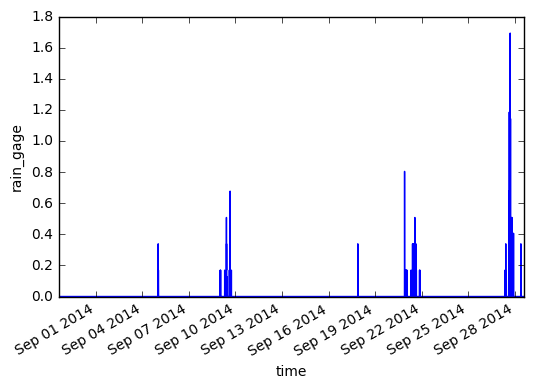

In [101]:
%matplotlib inline
ds['rain_gage'].mean('station').plot();

In [102]:
ds.close()